# SUMMARY - w/mortgage rate added
---
#### NOTE:
 - Adding mortgage rate and mortgage points ultimately did not affect the model as both were insignificant with p-values well above 0.05.
 - Additionally, neither correlated well with $saleprice$ or $saleprice\_log$
 - Even still, it is possible the time period the dataset covers (2006-2010) or the geographic location (Ames, Iowa) is too limited to conclude whether mortgage rate has any effect whatsoever on housing prices in general.

***
## Data Cleaning
<br></br>
### data source
 - $houseprices$ data was sourced from the Thinkful database using the `sqlalchemy` package.

<br></br>
### variable sorting
 - data columns were collected as variables, and sorted into $cont_vars$ (continuous variables) and $cat_vars$ (categorical variables) lists.
 
<br></br>
### missing values
 - variables with many (17%-99%) missing values were removed from feature consideration.
 - variables with some (~5%) missing values were kept.

<br></br>
***
## Data Exploration
<br></br>
### saleprice distribution
 - plotted the distributions of saleprice and log(saleprice). The log-transformed saleprice appeared to be more normal.
 - added the log of the saleprice, $saleprice\_log$, to the dataframe for target variable consideration.

<br></br>
### inspecting categorical variables
 - unable to visually determine which categorical variables to consider for feature engineering.
 - implemented ANOVA test to rank categorical variables by the inverse of their p-values.
 
<br></br>
### inspecting continuous variables
 - too many variables to visually determine via correlation matrix which continuous variables correlated most with saleprice.
 - executed `.corrwith()` to determine correlation with saleprice only.
 
<br></br>
***
## Feature Engineering
<br></br>
### feature selection
 - included the top 10 categorical variables according to the ANOVA test as features
 - included the top 6 continuous variables most correlating with saleprice as features
 - used `.get_dummies()` to perform one-hot encoding on the categorical variables
 - replaced the original categorical variables from the dataframe with their dummy versions
  
<br></br>
### feature trimming
 - used `.corrwith()` to determine new correlation ranking, keeping the top 9 variables most correlating with saleprice
 - used correlation matrix to identify collinearity between features, removing features that highly correlated with other features but correlated less with saleprice than their collinear partner(s)
 - entered regression phase with 9 features and $saleprice$ as the target variable
  
<br></br>
***
## Regression
<br></br>
### wrapper functions
 - defined wrapper function to execute `sklearn` linear regression
 - defined wrapper function to execute `statsmodels` linear regression
 - both functions implemented a 20% holdout using `train_test_split` function
 
<br></br>
### regression results
 - after first attempt, removed feature identified as insignificant, resulting in 6 remaining features
 - regression resulted in 77% and 78% $R^2$ for train and test data sets respectively
 
<br></br>
#### model
 - target_variable = $saleprice$
 - features =
       ['overallqual', 'grlivarea', 'garagecars',
       'totalbsmtsf', 'foundation_PConc', 'neighborhood_NridgHt']
 
<br></br>
***
## Model Improvement I
<br></br>
### variable adjustment
 - switched to $saleprice\_log$ as the target variable
 - added synthetic variable, $totalsf$, summing up the total square footage (built from 3 separate square footage variables)
 - added interaction variable for overall quality ($overallqual$) and total square footage ($totalsf$)
 
<br></br>
#### model
 - target_variable = $saleprice\_log$
 - features =
       ['overallqual', 'grlivarea', 'garagecars',
       'foundation_PConc', 'neighborhood_NridgHt', 'totalsf',
       'int_overallqual_totalsf']
 
<br></br>
### regression results
 - regression resulted in 81% $R^2$ for both train and test data sets
 
<br></br>
***
## Model Improvement II
<br></br>
### categorical variable search
 - defined function to iterate through the remaining unused categorical variables and determine train and test $R^2$ values if each was added to the model
 - added the top 3 categorical variables from the returned dataframe to the model
 
<br></br>
### regression results
 - regression resulted in 86% and 85% $𝑅^2$ for train and test data sets respectively
 - Test $R^2$ improvement of 7% at the cost of 23 additional features (6 to 29) relative to the original model
 
<br></br>
#### model
 - target_variable = $saleprice\_log$
 - features = 
       ['overallqual', 'grlivarea', 'garagecars',
       'foundation_PConc', 'neighborhood_NridgHt', 'totalsf',
       'int_overallqual_totalsf', 'neighborhood_ClearCr',
       'neighborhood_CollgCr', 'neighborhood_Crawfor', 'neighborhood_NoRidge',
       'neighborhood_NridgHt', 'neighborhood_Somerst', 'neighborhood_StoneBr',
       'neighborhood_Timber', 'neighborhood_Veenker', 'mszoning_FV',
       'mszoning_RH', 'mszoning_RL', 'mszoning_RM', 'roofmatl_CompShg',
       'roofmatl_Membran', 'roofmatl_Metal', 'roofmatl_Roll',
       'roofmatl_Tar&Grv', 'roofmatl_WdShake', 'roofmatl_WdShngl']
 
<br></br>
***
## Ridge/Lasso/ElasticNet Regressions
 - OLS model better than Ridge, Lasso, ElasticNet regression models
 
|     |OLS   |Ridge |Lasso |ElasticNet|
|:-:  |:-:   |:-:   |:-:   |:-:       |
|Train|0.8633|0.8553|0.8466|0.8502    |
|Test |0.8497|0.8322|0.8234|0.8246    |
|MAE  |0.1200|0.1256|0.1263|0.1267    |
|MSE  |0.0251|0.0280|0.0294|0.0293    |
|RMSE |0.1583|0.1673|0.1716|0.1710    |
|MAPE |1.0033|1.0489|1.0557|1.0582    |

# SETUP
---

## import packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
#from scipy import stats as st
from sqlalchemy import create_engine


# sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, normalize, scale
from sklearn.decomposition import PCA

# statsmodels
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

import warnings
warnings.filterwarnings('ignore')

## define constants

In [2]:
ENABLE_PLOTS = False

## set plot style

In [3]:
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

## database credentials

In [4]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

## query database & create dataframe

In [5]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


## read csv and create mortgage data frame

In [6]:
df_mort = pd.read_csv('freddie_mac_mortgate_rates.csv')
df_mort.Rate = (df_mort.Rate/100).copy()
df_mort.columns = ['Year','Month','Mortgage_Rate','Mortgage_Points']
df_mort['Year_Month'] = df_mort.Year.astype(str) + '_' + df_mort.Month.astype(str)
df_mort.head()

,Year,Month,Mortgage_Rate,Mortgage_Points,Year_Month
0,2006,1,0.0615,0.5,2006_1
1,2006,2,0.0625,0.6,2006_2
2,2006,3,0.0632,0.6,2006_3
3,2006,4,0.0651,0.6,2006_4
4,2006,5,0.0660,0.5,2006_5


## Look up mortgage rates and points and add to data frame

In [7]:
# Add variable combining Year and Month sold into single value
df['Sold'] = df.yrsold.astype(str) + '_' + df.mosold.astype(str)

# Use new variable to look up Mortgage Rate and Points from mortgage data frame
# and add to the main data frame
df['Mortgage_Rate'] = df.Sold.apply(lambda x: df_mort.loc[df_mort.Year_Month == x].Mortgage_Rate.iloc[0])
df['Mortgage_Points'] = df.Sold.apply(lambda x: df_mort.loc[df_mort.Year_Month == x].Mortgage_Points.iloc[0])

# Check data frame
#df.head()
df[['Sold','Mortgage_Rate','Mortgage_Points']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 3 columns):
Sold               1460 non-null object
Mortgage_Rate      1460 non-null float64
Mortgage_Points    1460 non-null float64
dtypes: float64(2), object(1)
memory usage: 34.3+ KB


# DATA CLEANING
---

## variable sorting

In [8]:
# create list of continuous variables
cont_vars = list(df.select_dtypes(include=['int64','float64']).dtypes.to_frame('type').reset_index()['index'].values)
# id is numerical but is a categorical variable
cont_vars.remove('id')
# saleprice is numerical but is the target variable
cont_vars.remove('saleprice')

# create list of categorical variables
cat_vars = list(df.select_dtypes(exclude=['int64','float64']).dtypes.to_frame('type').reset_index()['index'].values)
# add id to list
cat_vars.append('id')

# define target variable
target_var = 'saleprice'

print('continuous variables\n---\n', cont_vars)
print()
print('categorical variables\n---\n', cat_vars)

continuous variables
---
 ['mssubclass', 'lotfrontage', 'lotarea', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf', 'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'miscval', 'mosold', 'yrsold', 'Mortgage_Rate', 'Mortgage_Points']

categorical variables
---
 ['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating', 'heatingqc', 'centralair', 'electrical',

## check for missing values

In [9]:
# create new data frame
df_missing = pd.DataFrame()

# count NULL values for each column
df_missing['Count'] = df.isnull().sum().sort_values(ascending=False)

# calculate percentage of rows are NULL for each column
df_missing['Percent'] = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)*100

# view non-zero NULL counts
df_missing[df_missing.Count > 0]

,Count,Percent
poolqc,1453,99.520548
miscfeature,1406,96.301370
alley,1369,93.767123
fence,1179,80.753425
fireplacequ,690,47.260274
lotfrontage,259,17.739726
garagefinish,81,5.547945
garagecond,81,5.547945
garagetype,81,5.547945
garageyrblt,81,5.547945


In [10]:
for col in df_missing[df_missing.Count > 0].reset_index()['index']:
    print(col,'\n---\n',df[col].unique(),'\n')

poolqc 
---
 [None 'Ex' 'Fa' 'Gd'] 

miscfeature 
---
 [None 'Shed' 'Gar2' 'Othr' 'TenC'] 

alley 
---
 [None 'Grvl' 'Pave'] 

fence 
---
 [None 'MnPrv' 'GdWo' 'GdPrv' 'MnWw'] 

fireplacequ 
---
 [None 'TA' 'Gd' 'Fa' 'Ex' 'Po'] 

lotfrontage 
---
 [ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
 105.  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.] 

garagefinish 
---
 ['RFn' 'Unf' 'Fin' None] 

garagecond 
---
 ['TA' 'Fa' None 'Gd' 'Po' 'Ex'] 

garagetype 
---
 ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' None 'Basment' '2Types'] 

garage

##### The following variables with missing values will not be used as features.
 - poolqc, miscfeature, alley, fence, fireplacequ, lotfrontage
 - Dropping rows with missing values in these columns would vastly reduce the number of data points.
 - Majority of these are categorical, therefore values cannot be interpolated.

<br></br>
##### All other variables with missing values are missing only ~5.55% of data
 - These will be kept in consideration for feature engineering

In [11]:
# list of excluded features
excluded_features = ['poolqc', 'miscfeature', 'alley', 'fence', 'fireplacequ', 'lotfrontage']

# iterate through list
for excluded in excluded_features:
    # remove from categorical variables list
    if excluded in cat_vars:
        cat_vars.remove(excluded)
    # remove from continuous variables list
    if excluded in cont_vars:  
        cont_vars.remove(excluded)

# DATA EXPLORATION
---

## saleprice distribution

In [12]:
# log-transform saleprice and add to df
df['saleprice_log'] = np.log(df.saleprice)

if ENABLE_PLOTS:
    # set figure size
    plt.rcParams["figure.figsize"] = (12,4)

    # plot saleprice distribution
    plt.subplot(1,2,1)
    sns.distplot(df.saleprice)
    plt.title('saleprice distribution', fontsize=30)
    plt.xticks(rotation=90)



    # plot saleprice_log distribution
    plt.subplot(1,2,2)
    sns.distplot(df.saleprice_log)
    plt.title('saleprice distribution (log)', fontsize=30)
    plt.xticks(rotation=90)

    plt.tight_layout()
    plt.savefig('housing_prices_distplot_saleprice')
    plt.show()

##### saleprice_log appears to have a more normal distribution than saleprice
 - Though saleprice_log, visually, has a more normal distribution, let's keep saleprice as the target variable.
 - We will still add saleprice_log into the dataframe and verify later that using it will improve the model.

## inspect categorical variables

### saleprice split by categorical variables

In [13]:
if ENABLE_PLOTS:
    # set figure size
    plt.rcParams['figure.figsize'] = (24,24)

    # initialize subplot counter
    i = 1

    # iterate through list of categorical variables
    for var in cat_vars:
        # plot each variable against saleprice
        plt.subplot(len(cat_vars)//5+1,5,i)
        sns.barplot(df.saleprice,df[var])
        i += 1

    plt.tight_layout()
    plt.savefig('housing_prices_barplot_cat_vars_vs_saleprice')
    plt.show()

### count records per categorical variable group

In [14]:
if ENABLE_PLOTS:
    # set figure size
    plt.rcParams['figure.figsize'] = (24,24)

    # initialize subplot counter
    i = 1

    # iterate through list of categorical variables
    for var in cat_vars:
        # plot count for each variable
        plt.subplot(len(cat_vars)//5+1,5,i)
        sns.countplot(df[var])
        i += 1

    plt.tight_layout()
    plt.savefig('housing_prices_countplot_cat_vars')
    plt.show()

### saleprice correlation, split by categorical variables

In [15]:
if ENABLE_PLOTS:
    # set figure size
    plt.rcParams['figure.figsize'] = (24,24)

    # initialize subplot counter
    i = 1

    # iterate through list of categorical variables
    for var in cat_vars:
        # plot each variable against saleprice
        plt.subplot(len(cat_vars)//5+1,5,i)
        for val in df[var].unique():
            sns.regplot(df[df[var] == val].overallqual,df[df[var] == val].saleprice, label=val)
            plt.title(f'saleprice vs. overallqual\nsplit by {var}')
            #plt.legend(title=var)
        i += 1
    plt.tight_layout()
    #plt.savefig('housing_prices_regplot_salepricelog_vs_cont_vars')
    plt.show()

##### It is difficult to visually rank categorical variables, so let's try ranking using the ANOVA test.

### anova test to rank categorical variables

#### define function

In [16]:
def anova_test(df_in, variables):

    # initialize empty data frame
    # this will be the return variable
    df_anv = pd.DataFrame()
    df_anv['feature'] = variables
    pvals = []
    
    # iterate through categorical variables
    for v in variables:
        
        # initialize empty samples list
        samples = [];
        
        # iterate through each feature's levels
        for level in df_in[v].unique():
            
            # collect the saleprices for each variable's levels
            prices = df_in[df_in[v] == level].saleprice.values
            samples.append(prices)
        
        # execute one-way ANOVA test and get p-value
        pval = st.f_oneway(*samples)[1]
        pvals.append(pval)
        
    df_anv['pval'] = pvals
    return df_anv.sort_values('pval')

#### plot categorical variable ranking

In [17]:
# execute anova test
a = anova_test(df, cat_vars)

# calculate and add disparity
a['disparity'] = np.log(1/a['pval'])

if ENABLE_PLOTS:
    # set figure size
    plt.rcParams['figure.figsize'] = (12,4)
    
    sns.barplot(data=a, x='feature', y='disparity')
    plt.title('Disparity of Categorical Features')
    plt.xticks(rotation=90)
    
    plt.tight_layout()
    plt.savefig('categorical_variables_ranked_by_disparity')
    plt.show()

##### Based on the rankings, we will consider the top 10 categorical variables above in feature engineering.

In [18]:
cat_feats = list(a.feature.values)[:10]
cat_feats

['neighborhood',
 'exterqual',
 'kitchenqual',
 'foundation',
 'heatingqc',
 'salecondition',
 'exterior1st',
 'exterior2nd',
 'saletype',
 'mszoning']

## inspect continuous variables

### regression plots (against saleprice)

In [19]:
if ENABLE_PLOTS:
    # set figure size
    plt.rcParams['figure.figsize'] = (24,24)

    # initialize subplot counter
    i = 1

    # iterate through list of categorical variables
    for var in cont_vars:
        # plot each variable against saleprice
        plt.subplot(len(cont_vars)//5+1,5,i)
        sns.regplot(df[var],df.saleprice)
        i += 1

    plt.tight_layout()
    plt.savefig('housing_prices_regplot_saleprice_vs_cont_vars')
    plt.show()

### correlation matrix

In [20]:
if ENABLE_PLOTS:
    # set figure size
    plt.rcParams['figure.figsize'] = (8,8)

    # plot heatmap
    sns.heatmap(df.corr(), square=True, linewidth=0.5)#, annot=True)

    plt.tight_layout()
    plt.show()

##### It is difficult to visually rank the continuous variables by correlation with saleprice. Instead we will use `.corrwith()` to correlate with saleprice only and sort the result.

### correlation with saleprice only

In [21]:
df.corrwith(df.saleprice).sort_values(ascending=False)

saleprice          1.000000
saleprice_log      0.948374
overallqual        0.790982
grlivarea          0.708624
garagecars         0.640409
garagearea         0.623431
totalbsmtsf        0.613581
firstflrsf         0.605852
fullbath           0.560664
totrmsabvgrd       0.533723
yearbuilt          0.522897
yearremodadd       0.507101
garageyrblt        0.486362
masvnrarea         0.477493
fireplaces         0.466929
bsmtfinsf1         0.386420
lotfrontage        0.351799
wooddecksf         0.324413
secondflrsf        0.319334
openporchsf        0.315856
halfbath           0.284108
lotarea            0.263843
bsmtfullbath       0.227122
bsmtunfsf          0.214479
bedroomabvgr       0.168213
screenporch        0.111447
poolarea           0.092404
mosold             0.046432
threessnporch      0.044584
Mortgage_Rate      0.028198
bsmtfinsf2        -0.011378
bsmthalfbath      -0.016844
Mortgage_Points   -0.019364
miscval           -0.021190
id                -0.021917
lowqualfinsf      -0

##### Based on the above list, we will consider the top 6 correlating variables (excluding saleprice and saleprice_log) for feature engineering.

In [22]:
cont_feats = list(df.corrwith(df.saleprice).sort_values(ascending=False).reset_index()['index'].values)[2:8]
cont_feats.append('Mortgage_Rate')
cont_feats.append('Mortgage_Points')
cont_feats

['overallqual',
 'grlivarea',
 'garagecars',
 'garagearea',
 'totalbsmtsf',
 'firstflrsf',
 'Mortgage_Rate',
 'Mortgage_Points']

In [23]:
if ENABLE_PLOTS:
    # set figure size
    plt.rcParams['figure.figsize'] = (12,4)

    # initialize subplot counter
    i = 1

    # iterate through list of categorical variables
    for var in cont_feats:
        # plot each variable against saleprice
        plt.subplot(2,3,i)
        sns.regplot(df[var],df.saleprice)
        i += 1

    plt.tight_layout()
    plt.savefig('housing_prices_regplot_saleprice_vs_cont_vars_top')
    plt.show()

# FEATURE ENGINEERING
---

## feature selection

In [24]:
features = cat_feats + cont_feats

# create new data frame with just the selected features and the target variable
df_feat = df[[target_var] + ['saleprice_log'] + features].copy()
df_feat.head()

,saleprice,saleprice_log,neighborhood,exterqual,kitchenqual,foundation,heatingqc,salecondition,exterior1st,exterior2nd,saletype,mszoning,overallqual,grlivarea,garagecars,garagearea,totalbsmtsf,firstflrsf,Mortgage_Rate,Mortgage_Points
0,208500,12.247694,CollgCr,Gd,Gd,PConc,Ex,Normal,VinylSd,VinylSd,WD,RL,7,1710,2,548,856,856,0.0592,0.5
1,181500,12.109011,Veenker,TA,TA,CBlock,Ex,Normal,MetalSd,MetalSd,WD,RL,6,1262,2,460,1262,1262,0.0626,0.4
2,223500,12.317167,CollgCr,Gd,Gd,PConc,Ex,Normal,VinylSd,VinylSd,WD,RL,7,1786,2,608,920,920,0.0604,0.7
3,140000,11.849398,Crawfor,TA,Gd,BrkTil,Gd,Abnorml,Wd Sdng,Wd Shng,WD,RL,7,1717,3,642,756,961,0.0625,0.6
4,250000,12.429216,NoRidge,Gd,Gd,PConc,Ex,Normal,VinylSd,VinylSd,WD,RL,8,2198,3,836,1145,1145,0.0529,0.7


### one-hot encoding categorical variables

In [25]:
# generate the one-hot encoding
dummies = pd.get_dummies(df_feat[cat_feats], drop_first=True)

# add the new columns to the data frame
features += dummies.columns.to_list()
df_feat = pd.concat([df_feat, dummies], axis=1)

# drop the original categorical variables replaced by their one-hot encoded versions
df_feat = df_feat.drop(cat_feats, axis=1).copy()

# view data frame
df_feat.head()

,saleprice,saleprice_log,overallqual,grlivarea,garagecars,garagearea,totalbsmtsf,firstflrsf,Mortgage_Rate,Mortgage_Points,...,saletype_ConLD,saletype_ConLI,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM
0,208500,12.247694,7,1710,2,548,856,856,0.0592,0.5,...,0,0,0,0,0,1,0,0,1,0
1,181500,12.109011,6,1262,2,460,1262,1262,0.0626,0.4,...,0,0,0,0,0,1,0,0,1,0
2,223500,12.317167,7,1786,2,608,920,920,0.0604,0.7,...,0,0,0,0,0,1,0,0,1,0
3,140000,11.849398,7,1717,3,642,756,961,0.0625,0.6,...,0,0,0,0,0,1,0,0,1,0
4,250000,12.429216,8,2198,3,836,1145,1145,0.0529,0.7,...,0,0,0,0,0,1,0,0,1,0


## feature trimming

### correlation with saleprice only

In [26]:
pd.DataFrame(df_feat.corrwith(df_feat.saleprice).sort_values(ascending=False)).head(20)

,0
saleprice,1.000000
saleprice_log,0.948374
overallqual,0.790982
grlivarea,0.708624
garagecars,0.640409
garagearea,0.623431
totalbsmtsf,0.613581
firstflrsf,0.605852
foundation_PConc,0.497734
exterqual_Gd,0.452466


##### For the model, we will keep the top 9 variables (exluding saleprice and saleprice_log) from the above sorted result as features.

In [27]:
model_feats = list(df_feat.corrwith(df.saleprice).sort_values(ascending=False).reset_index()['index'].values)[2:11]
model_feats.append('Mortgage_Rate')
model_feats.append('Mortgage_Points')
model_feats

['overallqual',
 'grlivarea',
 'garagecars',
 'garagearea',
 'totalbsmtsf',
 'firstflrsf',
 'foundation_PConc',
 'exterqual_Gd',
 'neighborhood_NridgHt',
 'Mortgage_Rate',
 'Mortgage_Points']

In [28]:
df_model = df_feat[[target_var] + ['saleprice_log'] + model_feats].copy()
df_model.head()

,saleprice,saleprice_log,overallqual,grlivarea,garagecars,garagearea,totalbsmtsf,firstflrsf,foundation_PConc,exterqual_Gd,neighborhood_NridgHt,Mortgage_Rate,Mortgage_Points
0,208500,12.247694,7,1710,2,548,856,856,1,1,0,0.0592,0.5
1,181500,12.109011,6,1262,2,460,1262,1262,0,0,0,0.0626,0.4
2,223500,12.317167,7,1786,2,608,920,920,1,1,0,0.0604,0.7
3,140000,11.849398,7,1717,3,642,756,961,0,0,0,0.0625,0.6
4,250000,12.429216,8,2198,3,836,1145,1145,1,1,0,0.0529,0.7


### drop features that highly correlate with other features

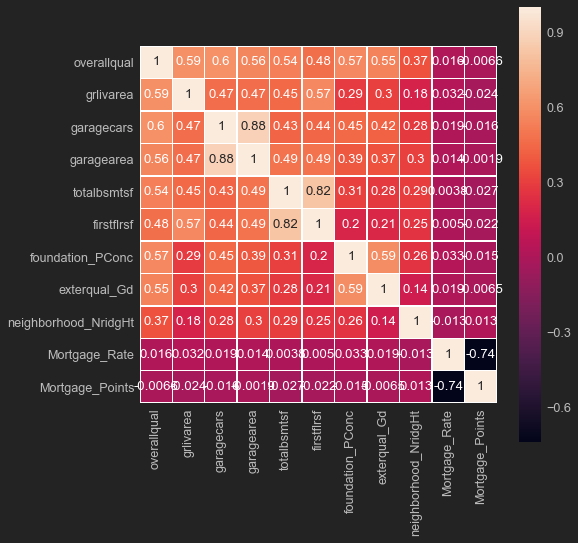

In [29]:
# set figure size
plt.rcParams['figure.figsize'] = (8,8)

# plot heatmap
sns.heatmap(df_model.drop(['saleprice','saleprice_log'], axis=1).corr(), square=True, linewidth=0.5, annot=True)

plt.show()

In [30]:
# removing garagearea as it correlates well with garagecars, which correlates better with saleprice
model_feats.remove('garagearea')
# removing firstflrsf as it correlates well with totalbsmtsf, which correlates better with saleprice
model_feats.remove('firstflrsf')

df_model = df_model.drop(['garagearea','firstflrsf'], axis=1).copy()
df_model.columns

Index(['saleprice', 'saleprice_log', 'overallqual', 'grlivarea', 'garagecars',
       'totalbsmtsf', 'foundation_PConc', 'exterqual_Gd',
       'neighborhood_NridgHt', 'Mortgage_Rate', 'Mortgage_Points'],
      dtype='object')

# REGRESSION
---

## define wrapper functions

In [31]:
def run_statsmodels_linreg(X, Y, print_summary=False):
    '''
    Executes statsmodels linear regression
    Inputs: X, Y
        X: explanatory variables
        Y: target variable
        print_summary: True, or False (default)
    '''   
    # train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)
    print('-----Split Breakdown-----')
    print(f'Train: {X_train.shape[0]}')
    print(f'Test: {X_test.shape[0]}')
    
    # add constant
    X_train = sm.add_constant(X_train)

    # run statsmodels OLS
    results = sm.OLS(y_train, X_train).fit()

    if print_summary:
        # print summary results
        print(results.summary())
    
    # return pvalues
    return results.pvalues

def run_sklearn_linreg(X, Y, regression_type='OLS', print_summary=False):
    '''
    Executes sklearn linear regression
    Inputs: x, y, regression_type, print_summary
        x: explanatory variables
        y: target variable
        regression_type: 'OLS' (default), 'Ridge', 'Lasso', or, 'ElasticNet'
        print_summary: True, or False (default)
    '''
    # train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)
    
    # run sklearn regression
    if regression_type == 'OLS':
        regression = LinearRegression()
    elif regression_type == 'Ridge':
        regression = RidgeCV(alphas=alphas, cv=5)
    elif regression_type == 'Lasso':
        regression = LassoCV(alphas=alphas, cv=5)
    elif regression_type == 'ElasticNet':
        regression = ElasticNetCV(alphas=alphas, cv=5)
    
    regression.fit(X_train, y_train)
    
    # predictions
    y_preds_train = regression.predict(X_train)
    y_preds_test = regression.predict(X_test)

    # return variables
    rsq_train = regression.score(X_train, y_train)
    rsq_test = regression.score(X_test, y_test)
    
    if print_summary:
        # print summary results
        print(f'{regression_type.upper()}')
        
        print('-----Split Breakdown-----')
        print(f'Train: {X_train.shape[0]}')
        print(f'Test: {X_test.shape[0]}')
        
        if regression_type != 'OLS':
            print(f'Best alpha: {regression.alpha_}')
        
        print('-----Model Score-----')
        print(f'Train R-Squared: {rsq_train:.4f}')
        print(f'Test R-Squared: {rsq_test:.4f}')
        print(f'Train-Test: {rsq_train-rsq_test:.4f}')
        
        print('-----Prediction statistics-----')
        # Prediction mean absolute error
        print(f'MAE: {mean_absolute_error(y_test, y_preds_test):.4f}')
        # Prediction mean squared error
        print(f'MSE: {mse(y_test, y_preds_test):.4f}')
        # Prediction root mean squared error
        print(f'RMSE: {rmse(y_test, y_preds_test):.4f}')
        # Prediction mean absolute percentage error
        print(f'MAPE: {np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100:.4f}%')
        print('')
    
    return rsq_train, rsq_test

## OLS

In [32]:
run_sklearn_linreg(df_model[model_feats], df_model[target_var], 'OLS', True)
print('---')
run_statsmodels_linreg(df_model[model_feats], df_model[target_var], True)

OLS
-----Split Breakdown-----
Train: 1168
Test: 292
-----Model Score-----
Train R-Squared: 0.7707
Test R-Squared: 0.7807
Train-Test: -0.0101
-----Prediction statistics-----
MAE: 24613.7411
MSE: 1472018143.1187
RMSE: 38366.8886
MAPE: 15.0607%

---
-----Split Breakdown-----
Train: 1168
Test: 292
                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     432.3
Date:                Wed, 05 Feb 2020   Prob (F-statistic):               0.00
Time:                        16:13:32   Log-Likelihood:                -13966.
No. Observations:                1168   AIC:                         2.795e+04
Df Residuals:                    1158   BIC:                         2.800e+04
Df Model:                           9                                    

const                   2.955190e-05
overallqual             1.382370e-47
grlivarea               2.482809e-57
garagecars              1.635203e-18
totalbsmtsf             5.009033e-17
foundation_PConc        1.071290e-02
exterqual_Gd            8.228280e-01
neighborhood_NridgHt    1.617194e-12
Mortgage_Rate           6.889373e-01
Mortgage_Points         7.420248e-01
dtype: float64

##### There are features that are not significant. Let's drop those and redo the regression.

In [33]:
model_feats.remove('exterqual_Gd')

df_model = df_model[[target_var] + ['saleprice_log'] + model_feats].copy()
df_model.columns

Index(['saleprice', 'saleprice_log', 'overallqual', 'grlivarea', 'garagecars',
       'totalbsmtsf', 'foundation_PConc', 'neighborhood_NridgHt',
       'Mortgage_Rate', 'Mortgage_Points'],
      dtype='object')

In [34]:
run_sklearn_linreg(df_model[model_feats], df_model[target_var], 'OLS', True)
run_statsmodels_linreg(df_model[model_feats], df_model[target_var], True)

OLS
-----Split Breakdown-----
Train: 1168
Test: 292
-----Model Score-----
Train R-Squared: 0.7706
Test R-Squared: 0.7807
Train-Test: -0.0101
-----Prediction statistics-----
MAE: 24627.6525
MSE: 1472376519.0905
RMSE: 38371.5587
MAPE: 15.0785%

-----Split Breakdown-----
Train: 1168
Test: 292
                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     486.8
Date:                Wed, 05 Feb 2020   Prob (F-statistic):               0.00
Time:                        16:13:33   Log-Likelihood:                -13966.
No. Observations:                1168   AIC:                         2.795e+04
Df Residuals:                    1159   BIC:                         2.799e+04
Df Model:                           8                                        

const                   2.523003e-05
overallqual             4.039844e-50
grlivarea               2.267871e-57
garagecars              8.157716e-19
totalbsmtsf             4.890557e-17
foundation_PConc        4.366923e-03
neighborhood_NridgHt    1.466447e-12
Mortgage_Rate           6.879309e-01
Mortgage_Points         7.396850e-01
dtype: float64

##### The R-squared for Train (77%) and Test (78%) sets indicating no overfitting; however
 - There is ~22-23% of the target's variance that remains unexplained, so there is room for improvement

# MODEL IMPROVEMENT I
---

## add new variables

In [35]:
# add new variable: total square footage consisting of first & second floor & basement square footages
df_model['totalsf'] = df.firstflrsf + df.secondflrsf + df.totalbsmtsf
model_feats.append('totalsf')

# remove totalbsmtsf
df_model = df_model.drop('totalbsmtsf', axis=1).copy()
model_feats.remove('totalbsmtsf')

# sanity check
df_model.columns

Index(['saleprice', 'saleprice_log', 'overallqual', 'grlivarea', 'garagecars',
       'foundation_PConc', 'neighborhood_NridgHt', 'Mortgage_Rate',
       'Mortgage_Points', 'totalsf'],
      dtype='object')

## add interaction

In [36]:
# add interaction between overallqual and totalsf to data frame
df_model['int_overallqual_totalsf'] = df_model.overallqual * df_model.totalsf
model_feats.append('int_overallqual_totalsf')

# sanity check
df_model.columns

Index(['saleprice', 'saleprice_log', 'overallqual', 'grlivarea', 'garagecars',
       'foundation_PConc', 'neighborhood_NridgHt', 'Mortgage_Rate',
       'Mortgage_Points', 'totalsf', 'int_overallqual_totalsf'],
      dtype='object')

## OLS

In [37]:
run_sklearn_linreg(df_model[model_feats], df_model['saleprice_log'], 'OLS', True)
print('---')
run_statsmodels_linreg(df_model[model_feats], df_model['saleprice_log'], True)

OLS
-----Split Breakdown-----
Train: 1168
Test: 292
-----Model Score-----
Train R-Squared: 0.8113
Test R-Squared: 0.8108
Train-Test: 0.0005
-----Prediction statistics-----
MAE: 0.1280
MSE: 0.0315
RMSE: 0.1776
MAPE: 1.0709%

---
-----Split Breakdown-----
Train: 1168
Test: 292
                            OLS Regression Results                            
Dep. Variable:          saleprice_log   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     553.3
Date:                Wed, 05 Feb 2020   Prob (F-statistic):               0.00
Time:                        16:13:33   Log-Likelihood:                 395.78
No. Observations:                1168   AIC:                            -771.6
Df Residuals:                    1158   BIC:                            -720.9
Df Model:                           9                                         
Covariance Ty

const                      0.000000e+00
overallqual                4.750200e-74
grlivarea                  2.789683e-04
garagecars                 5.540422e-29
foundation_PConc           1.670083e-05
neighborhood_NridgHt       1.879606e-05
Mortgage_Rate              3.648089e-01
Mortgage_Points            6.182232e-01
totalsf                    9.719587e-38
int_overallqual_totalsf    1.711802e-22
dtype: float64

##### We improved the model slightly by switching the target variable to saleprice_log and adding totalsf and the interaction between totalsf and overallqual
 - There is still 19-20% of the variance unexplaind by the features we have chosen.
 - Let's take another look at the categorical variables.

# MODEL IMPROVEMENT II
---

### back up model data frame for debug purposes

In [38]:
df_model_bkup = df_model.copy()

## find new categorical variables to add

### define function
 - function adds each categorical variable to the model and calculates train & test R-squared values
 - function produces a sorted daframe showing the train & test scores for each categorical variable added to the model

In [39]:
def find_new_cat_feats(df_in):
    potential_features = []
    for cat_var in cat_vars:
        cat_var = [cat_var]
        if cat_var[0] not in df_in.columns:

            df_temp = df_in.copy()
            
            # generate the one-hot encoding
            dummies = pd.get_dummies(df[cat_var], drop_first=True)

            # add dummy variables to data frame
            df_temp = pd.concat([df_temp, dummies], axis=1)
            

            rsq_train, rsq_test = run_sklearn_linreg(df_temp.drop(['saleprice', 'saleprice_log'], axis=1), df_temp['saleprice_log'], 'OLS', False)
            
            potential_features.append([cat_var[0], rsq_train, rsq_test])
            
    df_potential_features = pd.DataFrame(potential_features, columns=['variable','train_score','test_score'])
    df_potential_features['train_test_diff'] = df_potential_features.train_score - df_potential_features.test_score
    
    return df_potential_features.sort_values(by=['test_score'],ascending=False)

### execute function to score each categorical variable

In [40]:
new_cat_feats = find_new_cat_feats(df_model).copy().reset_index()
new_cat_feats.head()

,index,variable,train_score,test_score,train_test_diff
0,0,mszoning,0.837509,0.834623,0.002886
1,7,neighborhood,0.852323,0.834471,0.017852
2,13,roofmatl,0.825594,0.826446,-0.000852
3,27,centralair,0.823743,0.824562,-0.000819
4,23,bsmtfintype1,0.831101,0.824409,0.006692


In [41]:
new_cat_feats = list(new_cat_feats.loc[:2,'variable'].values)
new_cat_feats

['mszoning', 'neighborhood', 'roofmatl']

### add new categorical features to dataframe as one-hot encodings

In [42]:
# one-hot encoding
dummies = pd.get_dummies(df[new_cat_feats], drop_first=True)
df_model = pd.concat([df_model, dummies], axis=1)
df_model.columns

Index(['saleprice', 'saleprice_log', 'overallqual', 'grlivarea', 'garagecars',
       'foundation_PConc', 'neighborhood_NridgHt', 'Mortgage_Rate',
       'Mortgage_Points', 'totalsf', 'int_overallqual_totalsf', 'mszoning_FV',
       'mszoning_RH', 'mszoning_RL', 'mszoning_RM', 'neighborhood_Blueste',
       'neighborhood_BrDale', 'neighborhood_BrkSide', 'neighborhood_ClearCr',
       'neighborhood_CollgCr', 'neighborhood_Crawfor', 'neighborhood_Edwards',
       'neighborhood_Gilbert', 'neighborhood_IDOTRR', 'neighborhood_MeadowV',
       'neighborhood_Mitchel', 'neighborhood_NAmes', 'neighborhood_NPkVill',
       'neighborhood_NWAmes', 'neighborhood_NoRidge', 'neighborhood_NridgHt',
       'neighborhood_OldTown', 'neighborhood_SWISU', 'neighborhood_Sawyer',
       'neighborhood_SawyerW', 'neighborhood_Somerst', 'neighborhood_StoneBr',
       'neighborhood_Timber', 'neighborhood_Veenker', 'roofmatl_CompShg',
       'roofmatl_Membran', 'roofmatl_Metal', 'roofmatl_Roll',
       'roofmatl_

### rerun OLS

In [43]:
run_sklearn_linreg(df_model.drop(['saleprice','saleprice_log'], axis=1), df_model['saleprice_log'], 'OLS', True)
pvalues = run_statsmodels_linreg(df_model.drop(['saleprice','saleprice_log'], axis=1), df_model['saleprice_log'], False)

OLS
-----Split Breakdown-----
Train: 1168
Test: 292
-----Model Score-----
Train R-Squared: 0.8680
Test R-Squared: 0.8558
Train-Test: 0.0121
-----Prediction statistics-----
MAE: 0.1160
MSE: 0.0240
RMSE: 0.1551
MAPE: 0.9694%

-----Split Breakdown-----
Train: 1168
Test: 292


### remove variables with high p-values

In [44]:
pvalues = pvalues.to_frame().reset_index()
pvalues.columns = ['parameter','pvalue']
df_model = df_model.drop(list(pvalues[pvalues.pvalue > 0.05].parameter),axis=1).copy()

### rerun OLS

In [45]:
run_sklearn_linreg(df_model.drop(['saleprice','saleprice_log'], axis=1), df_model['saleprice_log'], 'OLS', True)
print('---')
run_statsmodels_linreg(df_model.drop(['saleprice','saleprice_log'], axis=1), df_model['saleprice_log'], True)

OLS
-----Split Breakdown-----
Train: 1168
Test: 292
-----Model Score-----
Train R-Squared: 0.8633
Test R-Squared: 0.8497
Train-Test: 0.0136
-----Prediction statistics-----
MAE: 0.1200
MSE: 0.0251
RMSE: 0.1583
MAPE: 1.0033%

---
-----Split Breakdown-----
Train: 1168
Test: 292
                            OLS Regression Results                            
Dep. Variable:          saleprice_log   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     277.2
Date:                Wed, 05 Feb 2020   Prob (F-statistic):               0.00
Time:                        16:13:33   Log-Likelihood:                 583.99
No. Observations:                1168   AIC:                            -1114.
Df Residuals:                    1141   BIC:                            -977.3
Df Model:                          26                                         
Covariance Ty

const                      2.489660e-257
overallqual                 2.219812e-35
grlivarea                   2.544636e-06
garagecars                  2.838454e-25
foundation_PConc            1.927215e-03
neighborhood_NridgHt        2.047209e-11
totalsf                     1.362932e-20
int_overallqual_totalsf     1.638312e-05
mszoning_FV                 8.561623e-09
mszoning_RH                 4.061651e-05
mszoning_RL                 1.737429e-13
mszoning_RM                 5.671676e-06
neighborhood_ClearCr        2.912113e-04
neighborhood_CollgCr        1.091779e-03
neighborhood_Crawfor        3.388226e-10
neighborhood_NoRidge        7.983210e-07
neighborhood_NridgHt        2.047209e-11
neighborhood_Somerst        4.874630e-02
neighborhood_StoneBr        6.416136e-08
neighborhood_Timber         2.766088e-04
neighborhood_Veenker        5.198980e-03
roofmatl_CompShg            9.934332e-17
roofmatl_Membran            6.509362e-13
roofmatl_Metal              3.313249e-12
roofmatl_Roll   

In [46]:
df_model.columns

Index(['saleprice', 'saleprice_log', 'overallqual', 'grlivarea', 'garagecars',
       'foundation_PConc', 'neighborhood_NridgHt', 'totalsf',
       'int_overallqual_totalsf', 'mszoning_FV', 'mszoning_RH', 'mszoning_RL',
       'mszoning_RM', 'neighborhood_ClearCr', 'neighborhood_CollgCr',
       'neighborhood_Crawfor', 'neighborhood_NoRidge', 'neighborhood_NridgHt',
       'neighborhood_Somerst', 'neighborhood_StoneBr', 'neighborhood_Timber',
       'neighborhood_Veenker', 'roofmatl_CompShg', 'roofmatl_Membran',
       'roofmatl_Metal', 'roofmatl_Roll', 'roofmatl_Tar&Grv',
       'roofmatl_WdShake', 'roofmatl_WdShngl'],
      dtype='object')

# Ridge/Lasso/ElasticNet Regression
---

In [47]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [48]:
run_sklearn_linreg(df_model.drop(['saleprice', 'saleprice_log'], axis=1), df_model['saleprice_log'], 'OLS', True)
run_sklearn_linreg(df_model.drop(['saleprice', 'saleprice_log'], axis=1), df_model['saleprice_log'], 'Ridge', True)
run_sklearn_linreg(df_model.drop(['saleprice', 'saleprice_log'], axis=1), df_model['saleprice_log'], 'Lasso', True)
run_sklearn_linreg(df_model.drop(['saleprice', 'saleprice_log'], axis=1), df_model['saleprice_log'], 'ElasticNet', True)

OLS
-----Split Breakdown-----
Train: 1168
Test: 292
-----Model Score-----
Train R-Squared: 0.8633
Test R-Squared: 0.8497
Train-Test: 0.0136
-----Prediction statistics-----
MAE: 0.1200
MSE: 0.0251
RMSE: 0.1583
MAPE: 1.0033%

RIDGE
-----Split Breakdown-----
Train: 1168
Test: 292
Best alpha: 1.0
-----Model Score-----
Train R-Squared: 0.8553
Test R-Squared: 0.8322
Train-Test: 0.0231
-----Prediction statistics-----
MAE: 0.1256
MSE: 0.0280
RMSE: 0.1673
MAPE: 1.0489%

LASSO
-----Split Breakdown-----
Train: 1168
Test: 292
Best alpha: 0.001
-----Model Score-----
Train R-Squared: 0.8466
Test R-Squared: 0.8234
Train-Test: 0.0232
-----Prediction statistics-----
MAE: 0.1263
MSE: 0.0294
RMSE: 0.1716
MAPE: 1.0557%

ELASTICNET
-----Split Breakdown-----
Train: 1168
Test: 292
Best alpha: 0.001
-----Model Score-----
Train R-Squared: 0.8502
Test R-Squared: 0.8246
Train-Test: 0.0256
-----Prediction statistics-----
MAE: 0.1267
MSE: 0.0293
RMSE: 0.1710
MAPE: 1.0582%



(0.8501652770033981, 0.8245694844593991)

#### The linear regression models in order from best to worst are:
1. OLS
2. Ridge
3. ElasticNet $\approx$ Lasso

<br></br>

|     |OLS   |Ridge |Lasso |ElasticNet|
|:-:  |:-:   |:-:   |:-:   |:-:       |
|Train|0.8633|0.8553|0.8466|0.8502    |
|Test |0.8497|0.8322|0.8234|0.8246    |
|MAE  |0.1200|0.1256|0.1263|0.1267    |
|MSE  |0.0251|0.0280|0.0294|0.0293    |
|RMSE |0.1583|0.1673|0.1716|0.1710    |
|MAPE |1.0033|1.0489|1.0557|1.0582    |
